#  Data Loading, Storage, and File Formats

In [1]:
import numpy as np
import pandas as pd
import os
import sys

## Reading and Writing Data in Text Format

pandas features a number of functions for reading tabular data as a DataFrame object.

![alt text](images/parsingdata.png "Parsing functions in pandas")

The optional arguments for these functions may fall into a few categories:

- Indexing: can treat one or more columns as the returned DataFrame, and whether to get column names from the file, the user, or not at all.

- Type inference and data conversion: This includes the user-defined value conversions and custom list of missing value markers.

- Datetime parsing: Includes combining capability, including combining date and time information spread over multiple columns into a single column in the result.

- Iterating: Supports for iterating over chunks of very large files.

- Unclean data issues: Skipping rows or a footer, comments, or other minor things like numeric data with thousands separated by commas.

Some of these functions, like `pandas.read_csv`, perform *type inference*, because the column data types are not part of the data format. That means you don't necessarily have to specify which columns are numeric, integer, boolean, or string. Other data formats, like HDF5, Feather, and msgpack, have the data types stored in the format.

In [2]:
!cat examples/ex1.csv




2, 5, 7, 1 

In [3]:
examples_dir = "examples"

In [4]:
df = pd.read_csv(os.path.join(examples_dir, "ex1.csv"))

In [5]:
df

,a,b,c,d
0,2,5,7,8
1,1,6,8,4
2,2,5,7,1


We could also have used `read_table` and specified the delimiter:

In [6]:
pd.read_table(os.path.join(examples_dir, "ex1.csv"), sep=",")

,a,b,c,d
0,2,5,7,8
1,1,6,8,4
2,2,5,7,1


A file will not always have a header row. 

In [7]:
!cat examples/ex2.csv



2, 5, 7, 1, nice 

In [8]:
pd.read_csv(os.path.join(examples_dir, "ex2.csv"), header=None)

,0,1,2,3,4
0,2,5,7,8,alo
1,1,6,8,4,big
2,2,5,7,1,nice


You can allow pandas to assign default column names, or you can specify names yourself:

In [9]:
pd.read_csv(
    os.path.join(examples_dir, "ex2.csv"), names=["a", "b", "c", "d", "message"]
)

,a,b,c,d,message
0,2,5,7,8,alo
1,1,6,8,4,big
2,2,5,7,1,nice


Suppose you wanted the message column to be the index of the returned DataFrame. You can either indicate you want the column at index 4 or named 'message' using the `index_col` argument:

In [10]:
names = ["a", "b", "c", "d", "message"]

In [11]:
pd.read_csv(os.path.join(examples_dir, "ex2.csv"), names=names, index_col="message")

,a,b,c,d
message,,,,
alo,2,5,7,8
big,1,6,8,4
nice,2,5,7,1


In the case that you want to form a hierarchical index from multiple columns, pass a list of column numbers or names:

In [12]:
parsed = pd.read_csv(
    os.path.join(examples_dir, "csv_mindex.csv"), index_col=["key1", "key2"]
)

In [13]:
parsed

value1  value2
key1 key2                
one  a          1       2
     b          3       4
     c          5       6
     d          7       8
two  a          9      10
     b         11      12
     c         13      14
     d         15      16

In some cases, a table might not have a fixed delimiter, using whitespace or some other pattern to separate fields. Consider a text file that looks like this:

In [14]:
list(open(os.path.join(examples_dir, "ex3.txt")))

['            A         B         C\n',
 'aaa -0.264438 -1.026059 -0.619500\n',
 'bbb  0.927272  0.302904 -0.032399\n',
 'ccc -0.264273 -0.386314 -0.217601\n',
 'ddd -0.871858 -0.348382  1.100491']

While you could do some munging by hand, the fields here are separated by a variable amount of whitespace. In these cases, you can pass a regular expression as a delimiter for `read_table`. This can be expressed by the regular expression `\\s+`, so we have then:

In [15]:
pd.read_table(os.path.join(examples_dir, "ex3.txt"), sep="\s+")

,A,B,C
aaa,-0.264438,-1.026059,-0.619500
bbb,0.927272,0.302904,-0.032399
ccc,-0.264273,-0.386314,-0.217601
ddd,-0.871858,-0.348382,1.100491


Because there was one fewer column name than the number of data rows, `read_table` infers that the first column should be the DataFrame’s index in this special case.

![alt text](images/readcsvargs.png "Some read_csv/read_table function arguments")

You can skip the first, third, and fourth rows of a file with `skiprows`:

In [16]:
!cat examples/ex4.csv







9,10,11,12,foo

In [17]:
pd.read_csv(os.path.join(examples_dir, "ex4.csv"), skiprows=[0, 2, 3])

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


Handling missing values is an important and frequently nuanced part of the file parsing process. Missing data is usually either not present (empty string) or marked by some `sentinel` value. By default, pandas uses a set of commonly occurring sentinels, such as **NA** and **NULL**:

In [18]:
!cat examples/ex5.csv




three,9,10,11,12,foo

In [19]:
result = pd.read_csv(os.path.join(examples_dir, "ex5.csv"))

In [20]:
result

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


In [21]:
pd.isnull(result)

,something,a,b,c,d,message
0,False,False,False,False,False,True
1,False,False,False,True,False,False
2,False,False,False,False,False,False


The `na_values` option can take either a list or set of strings to consider missing
values:

In [22]:
result = pd.read_csv(os.path.join(examples_dir, "ex5.csv"), na_values=["NULL"])

In [23]:
result

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


In [24]:
result = pd.read_csv(os.path.join(examples_dir, "ex5.csv"), na_values=["6"])

In [25]:
result

,something,a,b,c,d,message
0,one,1,2.0,3.0,4,NaN
1,two,5,NaN,NaN,8,world
2,three,9,10.0,11.0,12,foo


Different NA sentinels can be specified for each column in a dict:

In [26]:
sentinels = {"message": ["foo", "NA"], "something": ["two"]}

In [27]:
df = pd.read_csv(os.path.join(examples_dir, "ex5.csv"), na_values=sentinels)

In [28]:
df

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,NaN,5,6,NaN,8,world
2,three,9,10,11.0,12,NaN


In [29]:
df.columns[df.isna().any()].tolist()

['something', 'c', 'message']

### Reading Text Files in Pieces

Before we look at a large file, we make the pandas display settings more compact:

In [30]:
pd.options.display.max_rows = 10

In [31]:
result = pd.read_csv(os.path.join(examples_dir, "ex6.csv"))

In [32]:
result

,one,two,three,four,key
0,0.467976,-0.038649,-0.295344,-1.824726,L
1,-0.358893,1.404453,0.704965,-0.200638,B
2,-0.501840,0.659254,-0.421691,-0.057688,G
3,0.204886,1.074134,1.388361,-0.982404,R
4,0.354628,-0.133116,0.283763,-0.837063,Q
...,...,...,...,...,...
4195,0.467976,-0.038649,-0.295344,-1.824726,L
4196,-0.358893,1.404453,0.704965,-0.200638,B
4197,-0.501840,0.659254,-0.421691,-0.057688,G
4198,0.204886,1.074134,1.388361,-0.982404,R


If you want to only read a small number of rows (avoiding reading the entire file), specify that with `nrows`:

In [33]:
df = pd.read_csv(os.path.join(examples_dir, "ex6.csv"), nrows=5)

In [34]:
df.columns

Index(['one', 'two', 'three', 'four', 'key'], dtype='object')

To read a file in pieces, specify a `chunksize` as a number of rows:

In [35]:
chunker = pd.read_csv(os.path.join(examples_dir, "ex6.csv"), chunksize=500)

In [36]:
chunker

The `TextParser` object returned by `read_csv` allows you to iterate over the parts of the file according to the `chunksize`. 

 For example, we can iterate over ex6.csv, aggregating the value counts in the 'key' column like so:

In [37]:
chunker = pd.read_csv(os.path.join(examples_dir, "ex6.csv"), chunksize=1000)

In [38]:
for piece in chunker:
    print(piece.shape)

(1000, 5)
(1000, 5)
(1000, 5)
(1000, 5)
(200, 5)


In [39]:
chunker = pd.read_csv(os.path.join(examples_dir, "ex6.csv"), chunksize=1000)
tot = pd.Series([], dtype="int")
for piece in chunker:
    tot = tot.add(piece["key"].value_counts(), fill_value=0)

tot = tot.sort_values(ascending=False)

In [40]:
tot[:10]

 L    840.0
 B    840.0
 G    840.0
 R    840.0
 Q    840.0
dtype: float64

`TextParser` is also equipped with a `get_chunk` method that enables you to read pieces of an arbitrary size.

## Writing Data to Text Format

Data can also be exported to a delimited format. Let’s consider one of the CSV files read before:

In [41]:
data = pd.read_csv(os.path.join(examples_dir, "ex5.csv"))

In [42]:
data

,something,a,b,c,d,message
0,one,1,2,3.0,4,NaN
1,two,5,6,NaN,8,world
2,three,9,10,11.0,12,foo


In [43]:
data.to_csv(os.path.join(examples_dir, "out.csv"))

In [44]:
!cat examples/out.csv

,something,a,b,c,d,message
0,one,1,2,3.0,4,
1,two,5,6,,8,world
2,three,9,10,11.0,12,foo


Other delimiters can be used, of course (writing to `sys.stdout` so it prints the text result to the console):

In [45]:
data.to_csv(sys.stdout, sep="|")

|something|a|b|c|d|message
0|one|1|2|3.0|4|
1|two|5|6||8|world
2|three|9|10|11.0|12|foo


Missing values appear as empty strings in the output. You might want to denote them
by some other sentinel value:

In [46]:
data.to_csv(sys.stdout, na_rep="NULL")

,something,a,b,c,d,message
0,one,1,2,3.0,4,NULL
1,two,5,6,NULL,8,world
2,three,9,10,11.0,12,foo


With no other options specified, both the row and column labels are written. Both of
these can be disabled:

In [47]:
data.to_csv(sys.stdout, index=False, header=False)

one,1,2,3.0,4,
two,5,6,,8,world
three,9,10,11.0,12,foo


You can also write only a subset of the columns, and in an order of your choosing:

In [48]:
data.to_csv(sys.stdout, index=False, columns=["a", "b", "c"])

a,b,c
1,2,3.0
5,6,
9,10,11.0


Series also has a `to_csv` method:

In [49]:
dates = pd.date_range("1/1/2000", periods=7)

In [50]:
ts = pd.Series(np.arange(7), index=dates)

In [51]:
ts.to_csv(sys.stdout, header=None)

2000-01-01,0
2000-01-02,1
2000-01-03,2
2000-01-04,3
2000-01-05,4
2000-01-06,5
2000-01-07,6


### Working with Delimited Formats

It's possible to load most forms of tabular data from disk using functions like `pandas.read_table`. In some cases, however, some manual processing may be necessary.
It's not uncommon to receive a file with one or more malformed lines that trip up `read_table`. To illustrate the basic tools, consider a small .csv file:

In [52]:
!cat examples/ex7.csv

"a","b","c"
"1","2","3"
"1","2","3"


For any file with a single-character delimiter, you can use Python's built-in csv module. To use it, pass any open file or file-like object to `csv.reader`:

In [53]:
import csv

f = open(os.path.join(examples_dir, "ex7.csv"))

In [54]:
reader = csv.reader(f)

Iterating through the reader like a file yields tuples of values with any quote characters removed:

In [55]:
for line in reader:
    print(line)

['a', 'b', 'c']
['1', '2', '3']
['1', '2', '3']


From there, it's up to you to do the wrangling necessary to put the data in the form that you need it. Let's take this step by step. First, we read the file into a list of lines:

In [56]:
with open(os.path.join(examples_dir, "ex7.csv")) as f:
    lines = list(csv.reader(f))

Then, we split the lines into the header line and the data lines:

In [57]:
header, values = lines[0], lines[1:]

Then we can create a dictionary of data columns using a dictionary comprehension and the expression `zip(*values)`, which transposes rows to columns:

In [58]:
data_dict = {h: v for h, v in zip(header, zip(*values))}

In [59]:
data_dict

{'a': ('1', '1'), 'b': ('2', '2'), 'c': ('3', '3')}

CSV files come in many different flavors. To define a new format with a different delimiter, string quoting convention, or line terminator, we define a simple subclass
of `csv.Dialect`:

In [60]:
class my_dialect(csv.Dialect):
    lineterminator = "\n"
    delimiter = ";"
    quotechar = '"'
    quoting = csv.QUOTE_MINIMAL


reader = csv.reader(open(os.path.join(examples_dir, "ex7.csv")), dialect=my_dialect)

We can also give individual CSV dialect parameters as keywords to `csv.reader` without having to define a subclass:

In [61]:
reader = csv.reader(open(os.path.join(examples_dir, "ex7.csv")), delimiter="|")

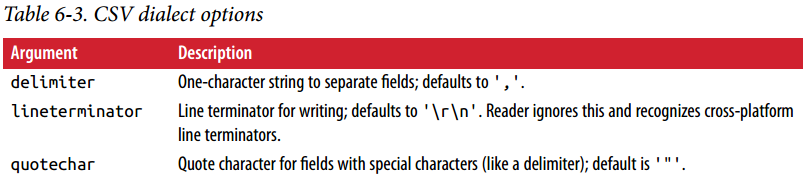

For files with more complicated or fixed multi-character delimiters, you will not be able to use the csv module. In those cases, you'll
have to do the line splitting and other cleanup using string's split method or the regular expression method `re.split`.

To write delimited files manually, you can use `csv.writer`. It accepts an open, writable file object and the same dialect and format options as `csv.reader`:

In [62]:
with open(os.path.join(examples_dir, "mydata.csv"), "w") as f:
    writer = csv.writer(f, dialect=my_dialect)
    writer.writerow(("one", "two", "three"))
    writer.writerow(("1", "2", "3"))
    writer.writerow(("4", "5", "6"))
    writer.writerow(("7", "8", "9"))

In [63]:
!cat examples/mydata.csv

one;two;three
1;2;3
4;5;6
7;8;9


## JSON Data

In [64]:
obj = """
{"name": "Wes",
"places_lived": ["United States", "Spain", "Germany"],
"pet": null,
"siblings": [{"name": "Scott", "age": 30, "pets": ["Zeus", "Zuko"]},
{"name": "Katie", "age": 38,
"pets": ["Sixes", "Stache", "Cisco"]}]
}
"""

To convert a JSON string to Python form, use `json.loads`:

In [65]:
import json

In [66]:
result = json.loads(obj)

In [67]:
type(result)

dict

In [68]:
result["siblings"]

[{'name': 'Scott', 'age': 30, 'pets': ['Zeus', 'Zuko']},
 {'name': 'Katie', 'age': 38, 'pets': ['Sixes', 'Stache', 'Cisco']}]

`json.dumps`, on the other hand, converts a Python object back to JSON:

In [69]:
asjson = json.dumps(result)

In [70]:
asjson

'{"name": "Wes", "places_lived": ["United States", "Spain", "Germany"], "pet": null, "siblings": [{"name": "Scott", "age": 30, "pets": ["Zeus", "Zuko"]}, {"name": "Katie", "age": 38, "pets": ["Sixes", "Stache", "Cisco"]}]}'

In [71]:
siblings = pd.DataFrame(result["siblings"], columns=["name", "age"])

In [72]:
siblings

,name,age
0,Scott,30
1,Katie,38


The `pandas.read_json` can automatically convert JSON datasets in specific arrangements into a Series or DataFrame. For example:

The default options for `pandas.read_json` assume that each object in the JSON array is a row in the table:

In [73]:
!cat examples/example.json



{"a": 7, "b": 8, "c": 9}]

In [74]:
data = pd.read_json(os.path.join(examples_dir, "example.json"))

In [75]:
data

,a,b,c
0,1,2,3
1,4,5,6
2,7,8,9


If you need to export data from pandas to JSON, one way is to use the `to_jso` methods on Series and DataFrame:

In [76]:
print(data.to_json())

{"a":{"0":1,"1":4,"2":7},"b":{"0":2,"1":5,"2":8},"c":{"0":3,"1":6,"2":9}}


In [77]:
print(data.to_json(orient="records"))

[{"a":1,"b":2,"c":3},{"a":4,"b":5,"c":6},{"a":7,"b":8,"c":9}]


### XML and HTML: Web Scraping

Python has many libraries for reading and writing data in the ubiquitous HTML and
XML formats. Examples include **lxml, Beautiful Soup, and html5lib**. While lxml is
comparatively much faster in general, the other libraries can better handle malformed
HTML or XML files.

pandas has a built-in function, `read_html`, which uses libraries like lxml and Beautiful Soup to automatically parse tables out of HTML files as DataFrame objects.

The `pandas.read_html` function has a number of options, but by default it searches for and attempts to parse all tabular data contained within \<table\> tags. The result is a list of DataFrame objects:

In [78]:
tables = pd.read_html(os.path.join(examples_dir, "tables.html"))

In [79]:
tables

[        0   1   2   3
 0    amir   2   3   6
 1  masoud  12  53  66
 2   saeed  26  32  61]

In [80]:
len(tables)

1

In [81]:
failures = tables[0]

In [82]:
failures

,0,1,2,3
0,amir,2,3,6
1,masoud,12,53,66
2,saeed,26,32,61


In [83]:
failures.sum()

0    amirmasoudsaeed
1                 40
2                 88
3                133
dtype: object

### Parsing XML with `lxml.objectify`

In [84]:
from lxml import objectify

In [85]:
path = os.path.join(examples_dir, "lstxml.xml")
parsed = objectify.parse(open(path))
root = parsed.getroot()

In [86]:
parsed

In [87]:
root

<Element ROOT at 0x7fe09d4339b0>

In [88]:
root.INDICATOR

<Element INDICATOR at 0x7fe09d43a4b0>

In [89]:
data = []
skip_fields = ["PARENT_SEQ", "INDICATOR_SEQ", "DESIRED_CHANGE", "DECIMAL_PLACES"]

In [90]:
for elt in root.INDICATOR:
    el_data = {}
    for child in elt.getchildren():
        if child.tag in skip_fields:
            continue
        el_data[child.tag] = child.pyval
    data.append(el_data)

In [91]:
data

[{'AGENCY_NAME': 'Metro-North Railroad',
  'INDICATOR_NAME': 'Escalator Availability',
  'DESCRIPTION': 'Percent of the time that escalators are operational\nsystemwide. The availability rate is based on physical observations performed\nthe morning of regular business days only. This is a new indicator the agency\nbegan reporting in 2009.',
  'PERIOD_YEAR': 2011,
  'PERIOD_MONTH': 12,
  'CATEGORY': 'Service Indicators',
  'FREQUENCY': 'M',
  'INDICATOR_UNIT': '%',
  'YTD_TARGET': 97.0,
  'YTD_ACTUAL': '',
  'MONTHLY_TARGET': 97.0,
  'MONTHLY_ACTUAL': ''}]

In [92]:
pd.DataFrame(data)

,AGENCY_NAME,INDICATOR_NAME,DESCRIPTION,PERIOD_YEAR,PERIOD_MONTH,CATEGORY,FREQUENCY,INDICATOR_UNIT,YTD_TARGET,YTD_ACTUAL,MONTHLY_TARGET,MONTHLY_ACTUAL
0,Metro-North Railroad,Escalator Availability,Percent of the time that escalators are operat...,2011,12,Service Indicators,M,%,97.0,,97.0,


XML data can get much more complicated than this example. Each tag can have metadata, too. Consider an HTML link tag, which is also valid XML:

In [93]:
from io import StringIO

tag = '<a href="http://www.google.com">Google</a>'
root = objectify.parse(StringIO(tag)).getroot()

In [94]:
root

<Element a at 0x7fe09d440550>

In [95]:
root.get("href")

'http://www.google.com'

In [96]:
root.text

'Google'

### Binary Data Formats

One of the easiest ways to store data (also known as serialization) efficiently in binary
format is using Python's built-in `pickle` serialization. pandas objects all have a `to_pickle` method that writes the data to disk in pickle format:

In [97]:
frame = pd.read_csv(os.path.join(examples_dir, "ex2.csv"))

In [98]:
frame

,2,5,7,8,alo
0,1,6,8,4,big
1,2,5,7,1,nice


In [99]:
frame.to_pickle(os.path.join(examples_dir, "frame_pickle"))

You can read any "pickled" object stored in a file by using the built-in **pickle** directly, or even more conveniently using `pandas.read_pickle`:

In [100]:
pd.read_pickle(os.path.join(examples_dir, "frame_pickle"))

,2,5,7,8,alo
0,1,6,8,4,big
1,2,5,7,1,nice


**pickle is only recommended as a short-term storage format. The problem is that it is hard to guarantee that the format will be stable over time; an object pickled today may not unpickle with a later version of a library.**

pandas has built-in support for two more binary data formats: _HDF5_ and _Message‐Pack_. Some other storage formats for pandas or NumPy data include: _bcolz_ and _Feather_

### Using HDF5 Format

HDF5 is a well-regarded file format intended for storing large quantities of scientific array data. The “HDF” in HDF5 stands for *hierarchical data format*. Each HDF5 file can store multiple datasets and supporting metadata. 

Compared with simpler formats, HDF5 supports on-the-fly compression with a variety of compression modes, enabling data with repeated patterns to be stored more efficiently. 

HDF5 can be a good choice for working with very large datasets that don't fit into memory, as you can efficiently read and write small sections of much larger arrays.

While it’s possible to directly access HDF5 files using either the PyTables or h5py
libraries, pandas provides a high-level interface that simplifies storing Series and
DataFrame object. The HDFStore class works like a dict and handles the low-level
details:

In [101]:
frame = pd.DataFrame({"a": np.random.randn(100)})

In [102]:
frame

,a
0,0.762644
1,0.293043
2,1.316844
3,-1.987389
4,0.412313
...,...
95,-0.556498
96,0.903743
97,0.091406
98,0.532966


In [103]:
store = pd.HDFStore(os.path.join(examples_dir, "mydata.h5"))

In [104]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: examples/mydata.h5

In [105]:
store["obj1"] = frame

In [106]:
store["obj1_col"] = frame["a"]

In [107]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: examples/mydata.h5

Objects contained in the HDF5 file can then be retrieved with the same dict-like API:

In [108]:
store["obj1"]

,a
0,0.762644
1,0.293043
2,1.316844
3,-1.987389
4,0.412313
...,...
95,-0.556498
96,0.903743
97,0.091406
98,0.532966


In [109]:
store["obj1_col"]

0     0.762644
1     0.293043
2     1.316844
3    -1.987389
4     0.412313
        ...   
95   -0.556498
96    0.903743
97    0.091406
98    0.532966
99   -0.005265
Name: a, Length: 100, dtype: float64

HDFStore supports two storage schemas, 'fixed' and 'table'. The latter is generally slower, but it supports query operations using a special syntax:

In [110]:
store.put("obj2", frame, format="table")

In [111]:
store.select("obj2", where=["index >= 10 and index <= 15"])

,a
10,-0.209169
11,-0.350109
12,1.166720
13,-0.466908
14,1.329499
15,-0.541655


In [112]:
store.close()

The put is an explicit version of the `store['obj2'] = frame` method but allows us to set other options like the storage format.

The `pandas.read_hdf` function gives you a shortcut to these tools:

In [113]:
frame.to_hdf(os.path.join(examples_dir, "mydata.h5"), "obj3", format="table")

In [114]:
pd.read_hdf(os.path.join(examples_dir, "mydata.h5"), "obj3", where=["index < 5"])

,a
0,0.762644
1,0.293043
2,1.316844
3,-1.987389
4,0.412313


If you work with large quantities of data locally,explore PyTables and h5py to see how they can suit your needs. Since many data analysis problems are I/O-bound (rather than CPU-bound), using a tool like HDF5 can massively accelerate your applications.

HDF5 is not a database. It is best suited for write-once, read-many datasets. While data can be added to a file at any time, if multiple writers do so simultaneously, the file can become corrupted.

If you are processing data that is stored on remote servers, like Amazon S3 or HDFS, using a different binary format designed for distributed storage like **Apache Parquet** may be more suitable.

### Reading Microsoft Excel Files

pandas also supports reading tabular data stored in Excel 2003 (and higher) files using either the `ExcelFile` class or `pandas.read_excel` function. 
Internally these tools use the add-on packages `xlrd` and `openpyxl` to read XLS and XLSX files, respectively.
To use `ExcelFile`, create an instance by passing a path to an xls or xlsx file:

In [115]:
xlsx = pd.ExcelFile(os.path.join(examples_dir, "ex1.xlsx"))

In [116]:
xlsx

Data stored in a sheet can then be read into DataFrame with `parse`:

In [117]:
pd.read_excel(xlsx, "Sheet1")

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


If you are reading multiple sheets in a file, then it is faster to create the ExcelFile, but you can also simply pass the filename to `pandas.read_excel`:

In [118]:
frame = pd.read_excel(os.path.join(examples_dir, "ex1.xlsx"), "Sheet1")

In [119]:
frame

,a,b,c,d,message
0,1,2,3,4,hello
1,5,6,7,8,world
2,9,10,11,12,foo


To write pandas data to Excel format, you must first create an `ExcelWriter`, then write data to it using pandas objects' `to_excel` method:

In [120]:
writer = pd.ExcelWriter(os.path.join(examples_dir, "ex2.xlsx"))

In [121]:
frame.to_excel(writer, "Sheet1")

In [122]:
writer.save()

In [123]:
frame.to_excel(os.path.join(examples_dir, "ex2.xlsx"))

## Interacting with Web APIs

There are a number of ways to access these APIs from Python; one easy-to-use method that I recommend is the **requests** package.

In [124]:
import requests

url = "https://api.github.com/repos/pandas-dev/pandas/issues"
resp = requests.get(url)

In [125]:
resp

<Response [200]>

In [126]:
data = resp.json()
data[0]["title"]

'RLS: 1.4.4'

In [127]:
pd.DataFrame(data, columns=["number", "title", "labels", "state"])

,number,title,labels,state
0,47485,RLS: 1.4.4,"[{'id': 131473665, 'node_id': 'MDU6TGFiZWwxMzE...",open
1,47484,QST: How to write non-optional fields in Parq...,"[{'id': 34444536, 'node_id': 'MDU6TGFiZWwzNDQ0...",open
2,47483,BUG: using read_xml with iterparse and names w...,"[{'id': 76811, 'node_id': 'MDU6TGFiZWw3NjgxMQ=...",open
3,47482,CI: Run all code checks even if one fails,"[{'id': 48070600, 'node_id': 'MDU6TGFiZWw0ODA3...",open
4,47481,BUG: Fix issues with numeric_only deprecation,"[{'id': 76811, 'node_id': 'MDU6TGFiZWw3NjgxMQ=...",open
...,...,...,...,...
25,47447,BUG: pd.pivot_table margins don't include rows...,"[{'id': 134699, 'node_id': 'MDU6TGFiZWwxMzQ2OT...",open
26,47446,Deprecate non-keyword arguments for rsplit,"[{'id': 57522093, 'node_id': 'MDU6TGFiZWw1NzUy...",open
27,47444,PDEP-1: Purpose and guidelines for pandas enha...,"[{'id': 1508144531, 'node_id': 'MDU6TGFiZWwxNT...",open
28,47443,CI/PERF: Windows builds fail due to potential ...,"[{'id': 48070600, 'node_id': 'MDU6TGFiZWw0ODA3...",open


### Interacting with Databases

In [128]:
import sqlite3

query = """
CREATE TABLE test (a VARCHAR(20), b VARCHAR(20), c REAL, d INTEGER);
"""

In [129]:
con = sqlite3.connect(os.path.join(examples_dir, "mydata.sqlite"))

In [130]:
con.execute(query)
con.commit()

Then, insert a few rows of data:

In [131]:
data = [
    ("Atlanta", "Georgia", 1.25, 6),
    ("Tallahassee", "Florida", 2.6, 3),
    ("Sacramento", "California", 1.7, 5),
]

In [132]:
stmt = "INSERT INTO test VALUES(?, ?, ?, ?)"

In [133]:
con.executemany(stmt, data)

In [134]:
con.commit()

Most Python SQL drivers (PyODBC, psycopg2, MySQLdb, pymssql, etc.) return a list of tuples when selecting data from a table:

In [135]:
cursor = con.execute("select * from test")
rows = cursor.fetchall()

You can pass the list of tuples to the DataFrame constructor, but you also need the column names, contained in the cursor’s description attribute:

In [136]:
cursor.description

(('a', None, None, None, None, None, None),
 ('b', None, None, None, None, None, None),
 ('c', None, None, None, None, None, None),
 ('d', None, None, None, None, None, None))

In [137]:
pd.DataFrame(rows, columns=[x[0] for x in cursor.description])

,a,b,c,d
0,Atlanta,Georgia,1.25,6
1,Tallahassee,Florida,2.60,3
2,Sacramento,California,1.70,5


The SQLAlchemy project is a popular Python SQL toolkit that abstracts away many of the common differences between SQL databases. pandas has a read_sql function that enables you to read data easily from a general SQLAlchemy connection. Here, we’ll connect to the same SQLite database with SQLAlchemy and read data from the table created before:

In [138]:
import sqlalchemy as sqla

In [139]:
db = sqla.create_engine("sqlite:///examples/mydata.sqlite")

In [140]:
pd.read_sql("select * from test", db)

,a,b,c,d
0,Atlanta,Georgia,1.25,6
1,Tallahassee,Florida,2.60,3
2,Sacramento,California,1.70,5
